<a href="https://colab.research.google.com/github/jeffrey96158/Vertical-Federated-Learning-without-explicit-ID-Matching/blob/main/Vertical_Federated_Learning_with_Drive_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install phe
!pip install cupy-cuda100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61.3 MB 148 kB/s 


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
# pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data
# others
from tqdm.notebook import tqdm as tqdm
import argparse
from sklearn.metrics import f1_score
from sklearn import preprocessing
import random

import matplotlib.pyplot as plt
import numpy as np
# import cupy as cp
import pandas as pd
# pallier
from phe import paillier


# Download Dataset from my Google drive



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/Sensorless_drive_diagnosis.txt', sep = " ", header = None)
df = df.sample(frac=1).reset_index(drop=True)
# data with (58509 instances) * (48 features + 1 answer)

# the class should between 0 - 10
df.iloc[:, -1] = df.iloc[:, -1].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


# split data into 8:1:1 for training, testing and validating
# pick 58200 data, train: 46560, test: 5820 validation: 5820
test_set = df.iloc[:5820, 0:49]
valid_set = df.iloc[5820: 11640, 0:49]
train_set = df.iloc[11640:58200, 0:49]






Mounted at /content/gdrive


# Argument

In [ ]:
parser = argparse.ArgumentParser(description='VFL with PyTorch')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=50, metavar='S',
                    help='random seed (default: 50)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 1)')
parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                    help='learning rate (default: 1e-3)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--batch-size', type=int, default=50, metavar='N',
                    help='input batch size for training (default: 50)')
parser.add_argument('--test-batch-size', type=int, default=50, metavar='N',
                    help='input batch size for testing (default: 50)')
parser.add_argument('--num-participants', type=int, default=12, metavar='NP',
                    help='number of participants (default: 12)')
parser.add_argument('--randomorder_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Random Order (default: 1)')
parser.add_argument('--asynchronous_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Asynchronous (default: 1)')
args = parser.parse_args(args=[])

#Class Defination

In [ ]:
## Initialization
# Control Seed
# CUDA is a GPU core for parrallel computing
torch.manual_seed(args.seed)

# Select Device
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else 'cpu')

if use_cuda:
    print("Using CUDA!")
    torch.cuda.manual_seed(args.seed)
else:
    print('Not using CUDA!!!')

# transform panda's dataframe into pytorch tensor
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

Using CUDA!


# Split data

In [ ]:
from torch.utils.data.dataset import TensorDataset
def Multi_Participants_SplitData(train_set,test_set,valid_set,p_num):
  split_train_set = [[] for i in range(p_num)]
  split_test_set = [[] for i in range(p_num)]
  split_valid_set = [[] for i in range(p_num)]
  # 根據participants數量將train set和test set切成n等分
  # split features
  col = int(48 / p_num)
  for i in range(p_num):
    temp = train_set.iloc[:,i*col:(i+1)*col]
    datas = temp.values
    #do normalization to datas
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(datas)
    datas = scaler.transform(datas)
    ans = train_set[48].values
    split_train_set[i] = TensorDataset(torch.FloatTensor(datas),torch.FloatTensor(ans))

    temp = test_set.iloc[:,i*col:(i+1)*col]
    datas = temp.values
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(datas)
    datas = scaler.transform(datas)
    ans = test_set[48].values
    split_test_set[i] = TensorDataset(torch.FloatTensor(datas),torch.FloatTensor(ans))

    temp = valid_set.iloc[:,i*col:(i+1)*col]
    datas = temp.values
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(datas)
    datas = scaler.transform(datas)
    ans = valid_set[48].values
    split_valid_set[i] = TensorDataset(torch.FloatTensor(datas),torch.FloatTensor(ans))

  TrainDataSet_dict = dict()
  TestDataSet_dict = dict()
  ValidDataSet_dict = dict()

  for i in range(p_num):
    p = 'P'
    p = p + str(i)
    TrainDataSet_dict[p] = data.DataLoader(dataset = split_train_set[i], batch_size = args.batch_size, shuffle=True, num_workers = 0)
    TestDataSet_dict[p] = data.DataLoader(dataset = split_test_set[i], batch_size = args.batch_size, shuffle=True, num_workers = 0)
    ValidDataSet_dict[p] = data.DataLoader(dataset = split_valid_set[i], batch_size = args.batch_size, shuffle=True, num_workers = 0)
    #print(TrainDataSet_dict[p])
  return TrainDataSet_dict, TestDataSet_dict, ValidDataSet_dict

# Training model

In [ ]:
class client_network(nn.Module):
  def __init__(self,features):
    super(client_network,self).__init__()
    self.features = features
    self.L1 = nn.Linear(features,30).double()
    self.L1B = nn.BatchNorm1d(30,dtype=torch.float64)
    self.L2 = nn.Linear(30,11).double()
    self.L2B = nn.BatchNorm1d(11,dtype=torch.float64)

    self.set_init(self.L1)
    self.set_init(self.L2)

  def set_init(self,layer):
    torch.nn.init.normal_(layer.weight,mean = 0., std = 1.)
    torch.nn.init.constant_(layer.bias,0)
  def forward(self,x):
    x = self.L1(x)
    x = self.L1B(x)
    x = F.relu(x)
    x = self.L2(x)
    x = self.L2B(x)
    x = F.relu(x)
    return x

class server_network(nn.Module):
  def __init__(self, p_num):
    super(server_network,self).__init__()
    self.p_num = p_num
    self.L3 = nn.Linear(11 * p_num ,20).double()
    self.L3B = nn.BatchNorm1d(20,dtype=torch.float64)
    self.output = nn.Linear(20,11).double()
    self.set_init(self.L3)
    self.set_init(self.output)
  def set_init(self,layer):
    torch.nn.init.normal_(layer.weight,mean = 0., std = 1.)
    torch.nn.init.constant_(layer.bias,0)
  def forward(self, x):
    x = self.L3(x)
    x = self.L3B(x)
    x = F.relu(x)
    x = self.output(x)
    return x

class Participants():
  def __init__(self,features_num):
    global device
    self.network = client_network(features_num).to(device)
    self.loss_fn = nn.CrossEntropyLoss()
    self.lr = args.lr
    self.optimizer = torch.optim.SGD(params=self.network.parameters(), lr = self.lr, weight_decay=1e-4)
  def LocalTrain(self,data):
    return self.network(data)

class GlobalServer():
  def __init__(self,participants_num,Participant_dic):
    global device
    self.global_network = server_network(participants_num).to(device)
    self.lr = args.lr
    para = list(self.global_network.parameters())
    for i in range(p_num):
      s = 'P'
      s = s + str(i)
      para = para + list(Participant_dict[s].network.parameters())
    self.optimizer = torch.optim.SGD(params=para , lr = self.lr, momentum = 0.9, weight_decay=1e-4)
    self.loss_fn = nn.CrossEntropyLoss()
  def ServerTrain(self,net_in):
    return self.global_network(net_in)


# Vertical Train

In [ ]:
def vertical_train(Participant_dict,Server,train_data,epochs,p_num):
  print(f'{p_num} participants training with {epochs} epochs')
  loss_history = list()
  accu_history = []
  testloss_history = []
  f1_history = []
  for e in tqdm(range(epochs)):
    correct = 0
    total_loss = 0
    Labels = []
    Predicts = []
    for i in range(len(train_data['P0'])):
      it = [0 for x in range(p_num)]
      data = [0 for x in range(p_num)]
      ans = [0 for x in range(p_num)]
      #next iteration
      for p in range(p_num):
        s = 'P'
        s = s + str(p)
        (data[p],ans[p]) = next(iter(train_data[s]))
        data[p],ans[p] = data[p].double(), ans[p].double()
        data[p],ans[p] = data[p].to(device),ans[p].to(device)
      #Client forward training
      client_out = [0 for x in range(p_num)]
      for p in range(p_num):
        s = 'P'
        s = s + str(p)
        client_out[p] = Participant_dict[s].LocalTrain(data[p])
      #Concat the output of client training
      c_out = torch.cat((client_out[0],client_out[1]),-1)
      for p in range(2,p_num,1):
          c_out = torch.cat((c_out,client_out[p]),-1)

      #Server training and calculate loss
      server_out = Server.ServerTrain(c_out)
      server_loss = Server.loss_fn(server_out, ans[0].long())

      #Sever backward
      Server.optimizer.zero_grad()
      server_loss.backward(retain_graph=True)
      Server.optimizer.step()

      loss_history.append(server_loss.cpu().detach().numpy())
      total_loss += server_loss.cpu().detach().numpy()

      predict = server_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
      correct += predict.eq(ans[0].data.view_as(predict)).sum().item()
      Labels = Labels + ans[0].tolist()
      Predicts = Predicts + predict.tolist()
    total_loss /= len(train_data['P0'])
    accuracy = 100. * correct / 46560
    f1 = f1_score(Labels, Predicts, average = "macro")

    testloss_history.append(total_loss)
    accu_history.append(accuracy / 100)
    f1_history.append(f1)
    #print(f1)

  print(f'Train set: Average loss: {total_loss:.4f}, Accuracy: {correct}/{5820} ({accuracy:.2f}%), F1-score: {f1:.4f}')
  return testloss_history, accu_history, f1_history

In [ ]:
def vertical_test(Participant_dict,Server,test_data,p_num):
  print(f'{p_num} participants test with {epochs} epochs')
  loss_history = list()
  total_loss = 0
  correct = 0
  Labels = []
  Predicts = []
  accu_history = []
  testloss_history = []

  for i in range(len(test_data['P0'])):
    it = [0 for x in range(p_num)]
    data = [0 for x in range(p_num)]
    ans = [0 for x in range(p_num)]
    #next iteration
    for p in range(p_num):
      s = 'P'
      s = s + str(p)
      (data[p],ans[p]) = next(iter(test_data[s]))
      data[p],ans[p] = data[p].double(), ans[p].double()
      data[p],ans[p] = data[p].to(device),ans[p].to(device)
    #Client forward training
    client_out = [0 for x in range(p_num)]
    for p in range(p_num):
      s = 'P'
      s = s + str(p)
      client_out[p] = Participant_dict[s].LocalTrain(data[p])
    #Concat the output of client training
    c_out = torch.cat((client_out[0],client_out[1]),-1)
    for p in range(2,p_num,1):
        c_out = torch.cat((c_out,client_out[p]),-1)
    #Server training
    server_out = Server.ServerTrain(c_out)

    #Calcualting loss
    server_loss = Server.loss_fn(server_out,ans[0].long())
    client_loss = [0 for x in range(p_num)]
    for p in range(p_num):
      client_loss[p] = Server.loss_fn(client_out[p], ans[p].long())


    loss_history.append(server_loss.cpu().detach().numpy())
    total_loss += server_loss.cpu().detach().numpy()

    predict = server_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct += predict.eq(ans[0].data.view_as(predict)).sum().item()
    Labels = Labels + ans[0].tolist()
    Predicts = Predicts + predict.tolist()

  total_loss /= len(test_data['P0'])
  accuracy = 100. * correct / 5820
  testloss_history.append(total_loss)
  accu_history.append(accuracy / 100)
  f1 = f1_score(Labels, Predicts, average = "macro")

  print(f'Test set: Average loss: {total_loss:.4f}, Accuracy: {correct}/{5820} ({accuracy:.2f}%), F1-score: {f1:.4f}')
  return accuracy


# Generate Participant

In [ ]:
def GenerateParticipant(p_num):
  P_dict = dict()
  for i in range(p_num):
    s = 'P'
    s = s + str(i)
    P_dict[s] = Participants(int(48/p_num))
  return P_dict

Start training data
2 participants training with 300 epochs


  0%|          | 0/300 [00:00<?, ?it/s]

Train set: Average loss: 0.2244, Accuracy: 42657/5820 (91.62%), F1-score: 0.9153
End training data
2 participants test with 300 epochs
Test set: Average loss: 0.5383, Accuracy: 4744/5820 (81.51%), F1-score: 0.8101


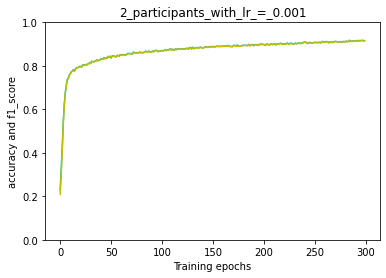

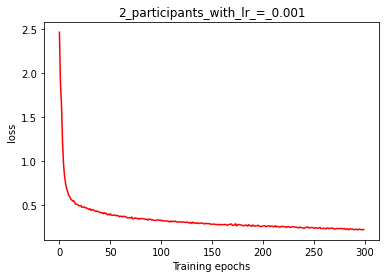

Start training data
3 participants training with 300 epochs


  0%|          | 0/300 [00:00<?, ?it/s]

Train set: Average loss: 0.2938, Accuracy: 40957/5820 (87.97%), F1-score: 0.8777
End training data
3 participants test with 300 epochs
Test set: Average loss: 0.6416, Accuracy: 4442/5820 (76.32%), F1-score: 0.7581


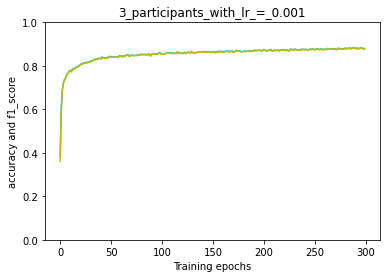

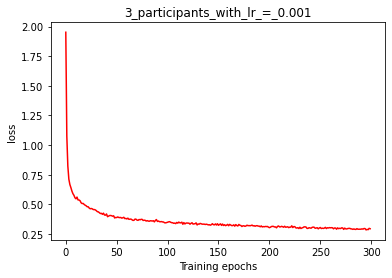

Start training data
4 participants training with 300 epochs


  0%|          | 0/300 [00:00<?, ?it/s]

Train set: Average loss: 0.4083, Accuracy: 38927/5820 (83.61%), F1-score: 0.8357
End training data
4 participants test with 300 epochs
Test set: Average loss: 0.4983, Accuracy: 4723/5820 (81.15%), F1-score: 0.8074


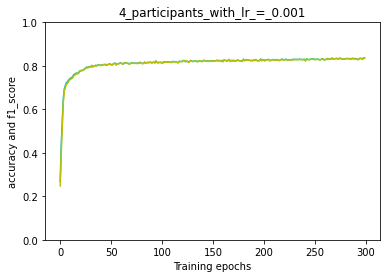

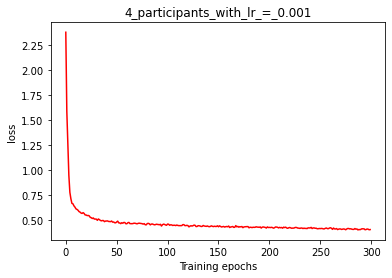

Start training data
6 participants training with 300 epochs


  0%|          | 0/300 [00:00<?, ?it/s]

Train set: Average loss: 1.0287, Accuracy: 26600/5820 (57.13%), F1-score: 0.5652
End training data
6 participants test with 300 epochs
Test set: Average loss: 1.1245, Accuracy: 3084/5820 (52.99%), F1-score: 0.5188


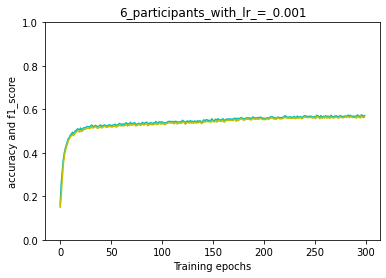

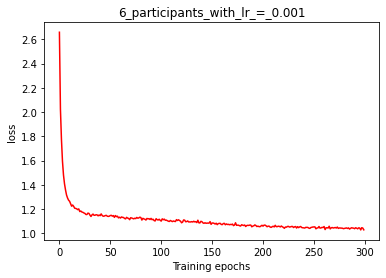

In [ ]:
from google.colab import files
from google.colab import output
output.disable_custom_widget_manager()
#設定train幾個epochs
epochs = 300
#設定圖片的儲存位置
images_dir = '/content/gdrive/My Drive/Images/Multi_Participant_Drive_Diagnosis_without_id_matching'

#設定幾個paticipants (要是48的因數)
P_list = [2, 3, 4, 6]
for p_num in P_list:
  #生成Participant
  Participant_dict = GenerateParticipant(p_num)
  Participant_keys = list(Participant_dict.keys())
  #生成Server
  Server = GlobalServer(p_num,Participant_dict)
  #切割DataSet
  TrainData_dict, TestData_dict, ValidData_dict = Multi_Participants_SplitData(train_set,test_set,valid_set,p_num)
  #開始training
  print('Start training data')
  train_loss, train_accuracy, train_f1 = vertical_train(Participant_dict,Server,TrainData_dict,epochs,p_num)
  print('End training data')
  #開始tesing
  vertical_test(Participant_dict, Server, TestData_dict, p_num)

  #做圖
  x_value = np.arange(0,len(train_loss),1)
  plt.plot(x_value,train_accuracy,color = 'c')
  plt.plot(x_value,train_f1,color = 'y')
  ax = plt.gca()
  ax.set_ylim([0, 1])
  plt.ylabel("accuracy and f1_score") # y label
  plt.xlabel("Training epochs") # x label
  s = str(p_num) + "_participants_with_lr_=_" + str(args.lr)
  plt.title(s)
  f = s + "_accuracy_and_f1-score.png"
  # plt.savefig(f"{images_dir}/{f}")
  plt.show()

  plt.plot(x_value,train_loss,color = 'r')
  plt.ylabel("loss") # y label
  plt.xlabel("Training epochs") # x label
  s = str(p_num) + "_participants_with_lr_=_" + str(args.lr)
  plt.title(s)
  f = s + "_loss.png"
  # plt.savefig(f"{images_dir}/{f}")
  plt.show()
